In [1]:
from IPython.display import Image

### IBM Advanced Data Science Capstone Project
#### Salvatore Salpietro

<hr/>

###### Purpose

The scope pf this project is to build a classifier to detect diseased lung from chest x-ray images, where the disease is pneumonia.

###### What is pneumonia

Pneumonia is an inflammatory lung disease that affects the small air sacs called alvioli.  

<img src="https://github.com/erotavlas/machine-learning/raw/main/IBMAdvancedDataScience_Capstone/images/pneumonia.jpg" width=350 />

###### Types
There are three main classification of pneumonia by location in the lungs, these are,

- Lobar and Multilobar pneumonia is an infection that involves one or more lobes, or section, of a lung. Lobar pneumonia is often due to Streptococcus pneumoniae (though Klebsiella pneumoniae is also possible.) Multilobar pneumonia involves more than one lobe, and it often causes a more severe illness.
- Bronchial pneumonia affects the lungs in patches around the tubes (bronchi or bronchioles).
- Interstitial pneumonia involves the areas in between the alveoli, and it may be called "interstitial pneumonitis." It is more likely to be caused by viruses or by atypical bacteria.

<img src="https://github.com/erotavlas/machine-learning/raw/main/IBMAdvancedDataScience_Capstone/images/types-of-pneumonia.jpeg" width=350 />

###### Symptoms
People with this condition typically exhibit the following symptoms of variable severity 
- cough 
- chest pain 
- fever 
- difficulty breathing. 

###### Causes
The causes are mainly due to viruses and bacteris but can also be from fungii, parasites or noninfectious causes.  

<img src="https://github.com/erotavlas/machine-learning/raw/main/IBMAdvancedDataScience_Capstone/images/causes.jpg" width=500>

###### Diagnosis
In order to verify a case of pneumonia in a patient, doctors rely on a combination of methods including observing physical signs, blood tests, and often a chest X-ray.  The chest X-ray is useful not only for diagnosis, but also to determine the extent of disease in the lungs.  

###### How does a doctor determine if a lung is diseased or not from chest X-rays?  
A chest X-ray is a radiology test that involves exposing the chest briefly to radiation to produce an image of the chest and the internal organs of the chest. An X-ray film is positioned against the body opposite the camera, which sends out a very small dose of a radiation beam. As the radiation penetrates the body, it is absorbed in varying amounts by different body tissues depending on the tissue's composition of air, water, blood, bone, or muscle. The X-ray image records these difference in penetration of the X-ray beam to produce an image of body tissue structures. The white shadows on chest X-ray represent areas where the beam is blocked by more dense or solid tissues, such as bone or heart.  The darker shadows on the chest X-ray represent areas where the x-ray beam penetrates more easily such as in air filled tissues like the lungs. 

Here is an example of chest x-rays for normal lung vs lung affected by pneumonia.
<img src="https://github.com/erotavlas/machine-learning/raw/main/IBMAdvancedDataScience_Capstone/images/normal_vs_pneumonia.png" width=500 />

Doctors look for lighter areas in the lung indicating the precense of inflammation and fluid buildup.  This causes areas of the lung to become lighter on the x-ray image compared to the darker air filled areas of healthy lungs.

###### Can AI assist in this process?
In this project we will attempt to create a machine learning model that will effectively automate what the doctor is doing when they screen a patient for lung disease, in this case the disease is pneumonia. By training the model on a set of healthy and diseased lung X-ray images, it will be able to distinguish between the two types.

### Importing libraries

In [2]:
# utilities 
import os
import random
import statistics
from tqdm import tqdm
from pathlib import Path
from natsort import natsorted, ns # natural sorting
from scipy.stats import norm
import numpy as np
import pandas as pd

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

# skimage
from skimage import io # allows to read images
from skimage.color import rgb2gray
from skimage.util import crop
from skimage.transform import resize

# sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn import svm

# sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve
from sklearn.metrics import auc as metrics_auc
from sklearn.model_selection import validation_curve, cross_val_score, cross_validate, StratifiedKFold, KFold

# tensorflow / keras
import tensorflow as tf
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

In [3]:
print(tf.__version__)

2.4.0


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2060 SUPER, compute capability 7.5
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [6]:
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


In [7]:
#physical_devices = tf.config.list_physical_devices()
#print(physical_devices)

In [8]:
device_spec = tf.DeviceSpec(job ="localhost", replica = 0, device_type = "GPU") 
print('Device Spec: ', device_spec.to_string()) 

Device Spec:  /job:localhost/replica:0/device:GPU:*


### Data analysis step

Determine the characteristics of the data and statistics 

#### 1. Data source

Data was obtained from the following source 
https://data.mendeley.com/datasets/rscbjbr9sj/3

We are provided with an archive file containing a set of chest x-rays.  Images are provided in two separate folders, test and train.  Within those folders images are separated into two classes - normal and pneumonia.  

```text
chest-xray
|__test
|  |__NORMAL
|  |__PNEUMONIA
|
|__train
   |__NORMAL
   |__PNEUMONIA```

#### 2. Characteristics of files

In [9]:
sizes = [] # sizes in kb
all_extensions = set([])
filenum = []
count = 0

test_images = []
test_labels = []

train_images = []
train_labels = []

# training set folder
for root, dirs, files in os.walk("E:\COURSES\Advanced Data Science With IBM\Advanced Data Science Capstone\\assignment\data\chest_xray\\train"):
    #print('dirs', dirs)
    for name in files:
        #print('name', name)
        #print(os.path.basename(root))
        
        file_name, file_extension = os.path.splitext(name)
        all_extensions.add(file_extension)
        
        stats = os.stat(os.path.join(root, name))
        count = count + 1
        
        sizes.append(stats.st_size/1000) 

        #if(stats.st_size/1000 < 12):
        #    discarded.append(os.path.join(root, name))
        #else:
        train_images.append(os.path.join(root, name))
        train_labels.append(os.path.basename(root))
        
        filenum.append(count)

# test set folder
for root, dirs, files in os.walk("E:\COURSES\Advanced Data Science With IBM\Advanced Data Science Capstone\\assignment\data\chest_xray\\test"):
    #print('dirs', dirs)
    for name in files:
        #print('name', name)
        #print(os.path.basename(root))
        
        file_name, file_extension = os.path.splitext(name)
        all_extensions.add(file_extension)

        stats = os.stat(os.path.join(root, name))
        count = count + 1
        
        sizes.append(stats.st_size/1000)
        
        #if(stats.st_size/1000 < 12):
        #    discarded.append(os.path.join(root, name))
        #else:
        test_images.append(os.path.join(root, name))
        test_labels.append(os.path.basename(root))
        
        filenum.append(count)

##### 2.1. File names

File names for images of dieases lungs contain a unique anonymized person number as well as the text 'bacteris' or 'virus' indicating if the pnemonia was caused by a virus or bacteris.  Example person426_virus_873

File names for images of normal lungs contain the work 'NORMAL'. Example - NORMAL2-IM-1250-0001

##### 2.2. File extensions

In [10]:
print(all_extensions)

{'.jpeg'}


Files are of types - jpeg

##### 2.3. Total number of image files

In [11]:
total_image_files = len(train_images) + len(test_images)

In [12]:
print(total_image_files)

5856


There are a total of 7197 files across both folders (test and train)

##### 2.4. Distribution of image files in test and train folders

In [13]:
len(test_images)

624

In [14]:
len(train_images)

5232

In [15]:
print('Train / Test split is about ', len(train_images) / total_image_files * 100, ' / ', 100 - len(train_images) / total_image_files * 100) 

Train / Test split is about  89.34426229508196  /  10.655737704918039


##### 2.5 Class distribution for training set

In [16]:
pneumonia = [i for i in train_labels if i == 'PNEUMONIA']
normal = [i for i in train_labels if i == 'NORMAL']

In [17]:
len(normal)

1349

In [18]:
len(pneumonia)

3883

In [19]:
print('There are ', len(pneumonia)/len(normal), ' more pneumonia images than normal images in the training set')

There are  2.878428465530022  more pneumonia images than normal images in the training set


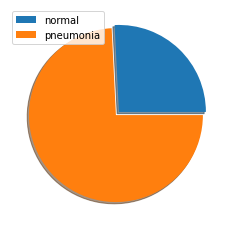

In [20]:
y = [len(normal), len(pneumonia)]
l = ["normal", "pneumonia"]
explode = (0.05, 0)  # explode 1st slice
patches, texts = plt.pie(y, explode=explode,  shadow=True )
plt.legend(patches, l, loc="best")
plt.show() 

##### 2.6 Image Histogram 

Lungs with pneumonia show up with areas that are lighter than lungs that are normal.  So we should expect there to be on average more light pixels in the pneumonia images and more dark pixels in the normal images. 

Here I am cropping the images by removing 20 pixels on all sides to isolate better the central portion of the lungs.  Then resizing to 128 x 128.  

Pixel values for each image are normalized to between 0 and 1 where 0 is black and 1 is white.
The average pixel intensity is taken for each image and a histogram is contructed for all images. 


In [21]:
t_n = []
t_p = []
ty_n = []
ty_p = []
for i in tqdm(range(len(train_images))):
    xray = resize(io.imread(train_images[i]),(128,128))
    xray = rgb2gray(xray)
    xray = crop(xray, (20), copy=False)
    xray = resize(xray,(128,128))
    
    l = train_labels[i]
    xray_flat = xray.flatten()
    xray_flat = xray_flat
    len_xray_flat = len(xray_flat)
    if l == 'NORMAL':
        lbl = 0
        t_n.append(sum(xray_flat)/len_xray_flat)
        ty_n.append(lbl)
    else:
        lbl = 1
        t_p.append(sum(xray_flat)/len_xray_flat)
        ty_p.append(lbl)        

  0%|                                                                                         | 0/5232 [00:00<?, ?it/s]c:\miniconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  import sys
100%|██████████████████████████████████████████████████████████████████████████████| 5232/5232 [05:29<00:00, 15.87it/s]


In [22]:
print(statistics.mean(t_p))
print(statistics.mean(t_n))
print(len(t_n))
print(len(t_p)) 

0.5629677531311426
0.539366948083682
1349
3883


We can see the mean pixel intensity for pneumonia is 0.56 (slightly closer to white) and for normal images it is 0.54 (slightly closer to black).  

In [23]:
df_hist = pd.DataFrame()
df_hist['normal'] = t_n
df_hist['pneumonia'] = random.sample(t_p, len(t_n)) # make the samples the same size (equal to the smaller of the two)

<AxesSubplot:ylabel='Count'>

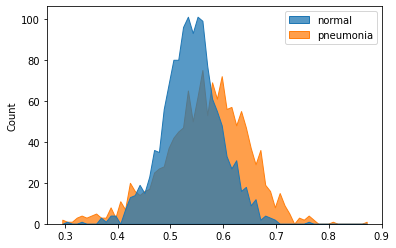

In [24]:
sns.histplot(df_hist, kde=False, bins=64, element="poly")

From the above histograms we can see that the pneumonia images are shifted in intensity towards the darker intensity, while the normal images are shifted toward the lighter pixel intensities.  

#### 4. Size of the images

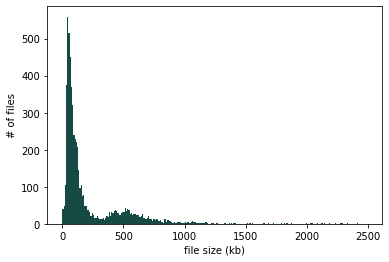

In [25]:

b = [i for i in range(0,2500,10)]

plt.xlabel('file size (kb)')
plt.ylabel('# of files')
plt.hist(sizes, bins=b,  color='#184A45FF')
plt.show()

Above is a histogram plot to show the ditribution of file sizes.  Most of the files are of size less than 1000 kb.

In [26]:
avg = sum(sizes)/len(sizes)
print(avg)

211.14802015027237


In [27]:
print(statistics.median(sizes))

95.839


In [28]:
print(min(sizes))

5.441


In [29]:
print(max(sizes))

2414.342


The mean file size is 211.148

The median file size is 95.839

The minimum file size observed is 5.441 kb

The maximum file size observed is 2412.342 kb

Sonce the file sizes are not all the same, some examination of the really small ans really large image files revealed that the really small images aspect ratio did not match those of the majority of images (i.e. they were longer in width than height and did not reveal the full chest/lung view).  These images might be considered outliers.  Further examination of the images below will attempt to exclude such outliers.  

#### 4. Aspect ratio of the images

The aspect ratio of an image is the ratio of its width to its height.
The formula is width / height.

Not all the images are of the same aspect ratio. On examining some of the images of smaller size, some did not show the full view of the chest and lungs.  We will remove these images.

If the shape of the image is longer in the x axis than it is in the y axis by certain threshold, then discard those images as they only show a section of the full chest image.

Choose something x/y must be less than or equal to 2 to constitute an acceptible image. (i.e. if the width is two or more times longer than the height then discard image)

In [30]:
temp_train_images = []
temp_train_labels = []

temp_test_images = []
temp_test_labels = []

discarded = []

for i in range(len(train_images)):
    xray = io.imread(train_images[i])
    y = xray.shape[0]
    x = xray.shape[1]
    ratio = x/y
    if ratio <= 2:
        temp_train_images.append(train_images[i])
        temp_train_labels.append(train_labels[i])
    else:
        discarded.append(train_images[i])
        
for i in range(len(test_images)):
    xray = io.imread(test_images[i])
    y = xray.shape[0]
    x = xray.shape[1]
    ratio = x/y
    if ratio <= 2:
        temp_test_images.append(test_images[i])
        temp_test_labels.append(test_labels[i])
    else:
        discarded.append(test_images[i])

In [31]:
print('updated train set, labels ', len(temp_train_images), len(temp_train_labels))
print('updated test set, labels ', len(temp_test_images), len(temp_test_labels))
print('discarded images ', len(discarded))

updated train set, labels  5116 5116
updated test set, labels  614 614
discarded images  126


Compare a discarded image to a remaining image in train set.

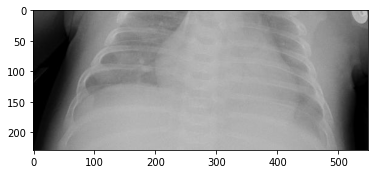

(229, 549, 3)


In [32]:
import matplotlib.pyplot as plt
im = io.imread(discarded[35])
imgplot = plt.imshow(im, cmap="gray")
plt.show()
print(im.shape)

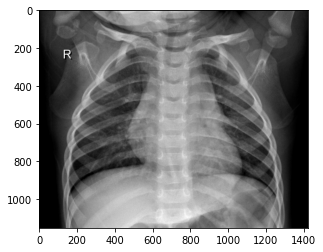

(1152, 1422)


In [33]:
im = io.imread(temp_train_images[1])
imgplot = plt.imshow(im, cmap="gray")
plt.show()
print(im.shape)

#### 4. Redistribute data to a train/validation / test split of 85/15/15

Now that the outliers have been removed, we can redistribute the data set to add some more images to the test set to bring the value up to 15%, and then split the remaining test set into a test and validation split of 85/15.

We won't touch the images in the test set, rather we will simply move some of the ones from the train set into the test set.

Using 15% instead of 20% because we son't have that many images to work with.

In [34]:
# new ratios after removing some outliers

total = len(temp_train_images) + len(temp_test_images)
print('total images = ', total)

percent_test = len(temp_test_images)/total
print('percent test ', percent_test*100)

percent_train = len(temp_train_images)/total
print('percent train ', percent_train*100)

total images =  5730
percent test  10.715532286212914
percent train  89.28446771378708


In [35]:
# calculate number of images to move from train set to test set

needed = 0.15*total
print(needed)

have = len(temp_test_images)
print(have)

difference = needed - have
print("need to add an additional ", difference, " images")

859.5
614
need to add an additional  245.5  images


In [36]:
# convert to pandas dataframe

# train set
data_train = {'file':temp_train_images,'label':temp_train_labels}
train_df = pd.DataFrame(data_train)

# test set
data_test = {'file':temp_test_images,'label':temp_test_labels}
test_df = pd.DataFrame(data_test)

In [37]:
train_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
1,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
2,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
3,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
4,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
...,...,...
5111,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
5112,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
5113,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
5114,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA


In [38]:
train_df['file'][2000], train_df['label'][2000]

('E:\\COURSES\\Advanced Data Science With IBM\\Advanced Data Science Capstone\\assignment\\data\\chest_xray\\train\\PNEUMONIA\\person1326_bacteria_3372.jpeg',
 'PNEUMONIA')

In [39]:
test_df['file'][200], test_df['label'][200]

('E:\\COURSES\\Advanced Data Science With IBM\\Advanced Data Science Capstone\\assignment\\data\\chest_xray\\test\\NORMAL\\NORMAL2-IM-0340-0001.jpeg',
 'NORMAL')

In [40]:
# first shuffle rows in train dataframe
train_df = train_df.sample(n = len(train_df), random_state=200).reset_index(drop=True)

In [41]:
# then move 245 rows from train dataframe to test dataframe
transferdata_df = train_df.iloc[-446:, 0:]

test_df = test_df.append(transferdata_df)

train_df = train_df.drop(transferdata_df.index)

In [42]:
# reset index of test_df
test_df = test_df.reset_index(drop=True)

In [43]:
train_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
1,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
2,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
3,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
...,...,...
4665,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
4666,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4667,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4668,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA


In [44]:
test_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
1,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
2,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
3,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
4,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
...,...,...
1055,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
1056,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
1057,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
1058,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA


In [45]:
# split train set further into train and validation set

newtrain_df = train_df.sample(frac=0.85,random_state=200) #random state is a seed value
validation_df = train_df.drop(newtrain_df.index)

In [46]:
train_df = newtrain_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

In [47]:
train_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
1,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
2,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
3,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
...,...,...
3965,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
3966,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
3967,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
3968,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL


In [48]:
validation_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
1,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
2,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
3,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
4,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
...,...,...
695,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
696,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
697,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
698,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA


We now have three data sets
- train_df (training set)
- validation_df (validation set)

- test_df (final test set)

#### 5. Shape and color of images

In [49]:
# Retrieving the geometry of the image and the number of pixels
# Images in scikit-image are represented by NumPy ndarrays. 
# Hence, many common operations can be achieved using standard NumPy methods for manipulating arrays

x = []
y = []
z = []
listofdataframes = [train_df, validation_df, test_df]

for df in listofdataframes:
    for index, row in df.iterrows():
        image = row['file']
        s = io.imread(image)
        x.append(s.shape[0])
        y.append(s.shape[1])
        if(len(s.shape) == 3):
            z.append(1)
        else:
            z.append(0)

In [50]:
df = pd.DataFrame({'x': x,
                   'y': y,
                   'z': z})

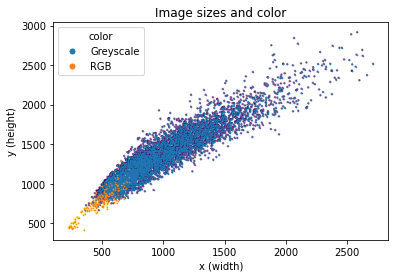

In [51]:
area = 2
plt.scatter(x, y, c=df.z, s=area,  alpha=0.5)
plt.title('Image sizes and color')
plt.xlabel('x (width)')
plt.ylabel('y (height)')
classes = [ 'Greyscale', 'RGB']
groups = df.groupby('z')
for name, group in groups:
    name = classes[0] if name == 0 else classes[1]
    plt.plot(group.x, group.y, marker='.', linestyle='', markersize=1, label=name)

plt.legend(title="color", markerscale=10)

plt.show()

 Since all the images are of different sizes, it will be necessary to reshape them to the same size.
 Also some are greyscale while other are RGB, so it will be necessary to normalize all images to the same color space (greyscale) 

## Data Preprocessing

The following steps need to be done in the data preprocessing step

- convert to greyscale
- grayscale normalization - to reduce the effect of illumination's differences.
Divide values by 255 to get a value between 0 and 1. NOTE: this already seems to be done automatically by scikit image

- image resize - to the same size - training, validation, and test set


In [52]:
x_train_img = []
y_train_img = []

for i in tqdm(range(len(train_df))):
    img = resize(io.imread(train_df.loc[i,'file']), (128,128))
    x_train_img.append(img)
    y_train_img.append(0 if train_df.loc[i,'label'] == 'NORMAL' else 1)

100%|██████████████████████████████████████████████████████████████████████████████| 3970/3970 [02:57<00:00, 22.33it/s]


In [53]:
x_val_img = []
y_val_img = []

for i in tqdm(range(len(validation_df))):
    img = resize(io.imread(validation_df.loc[i,'file']), (128,128))
    x_val_img.append(img)
    y_val_img.append(0 if validation_df.loc[i,'label'] == 'NORMAL' else 1)

100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [00:32<00:00, 21.31it/s]


In [54]:
x_test_img = []
y_test_img = []

for i in tqdm(range(len(test_df))):
    img = resize(io.imread(test_df.loc[i,'file']), (128,128))
    x_test_img.append(img)
    y_test_img.append(0 if test_df.loc[i,'label'] == 'NORMAL' else 1)

100%|██████████████████████████████████████████████████████████████████████████████| 1060/1060 [00:54<00:00, 19.35it/s]


In [55]:
for i in tqdm(range(len(x_train_img))):
    x_train_img[i] = rgb2gray(x_train_img[i])
    
for i in tqdm(range(len(x_val_img))):
    x_val_img[i] = rgb2gray(x_val_img[i])

for i in tqdm(range(len(x_test_img))):
    x_test_img[i] = rgb2gray(x_test_img[i])


  0%|                                                                                         | 0/3970 [00:00<?, ?it/s]c:\miniconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  
  0%|                                                                                          | 0/700 [00:00<?, ?it/s]c:\miniconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  """
  0%|                                                                          

## Image Augmentation

- In order to avoid overfitting problem, alter the training data with small transformations. 
- Some popular augmentations people use are horizontal flips, vertical flips, random crops, color jitters, translations, rotations, etc. 
- By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

Flip images horizontally

In [56]:
x_train_img_fl = [np.flip(img,-1) for img in x_train_img]
x_val_img_fl = [np.flip(img,-1) for img in x_val_img]

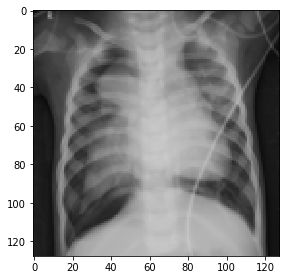

In [57]:
# verify flipped
io.imshow(x_train_img[0])

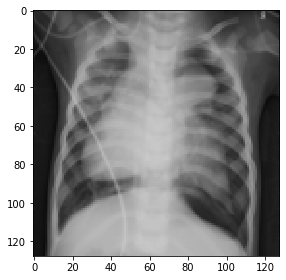

In [58]:
io.imshow(x_train_img_fl[0])

Crop then resize (simulate zoom)

In [59]:
x_train_img_cr = [resize(crop(i, (10), copy=False),(128,128)) for i in x_train_img]
x_val_img_cr = [resize(crop(i, (10), copy=False),(128,128)) for i in x_val_img]

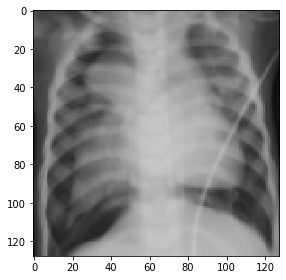

In [60]:
io.imshow(x_train_img_cr[0])

In [61]:
# append augmented images to train and validation sets

x_train_img = x_train_img + x_train_img_cr + x_train_img_fl
y_train_img = y_train_img + y_train_img + y_train_img
x_val_img = x_val_img + x_val_img_cr + x_val_img_fl
y_val_img = y_val_img + y_val_img + y_val_img


###  Calculate class weights

We will use the class_weights to correct for class imbalance to avoid a bias towards the majority class.

Formula to calculate the weight for a class

wj=n_samples / (n_classes * n_samplesj)

```text
wj is the weight for class j

n_samples is the total number of samples or rows in the dataset

n_classes is the total number of unique classes in the target

n_samplesj is the total number of rows of the respective class
```

In [62]:
normals = [i for i in y_train_img + y_val_img if i == 0]
print(len(normals))
pneumonias = [i for i in y_train_img + y_val_img if i == 1]
print(len(pneumonias))

3684
10326


In [63]:
n_samples = len(x_train_img) + len(x_val_img)
n_classes = 2
n_pneumonia = len(pneumonias)
n_normal = len(normals)

w_pneumonia = n_samples/(n_classes*n_pneumonia)
w_normal = n_samples/(n_classes*n_normal)

print("Number of pneumonia ", n_pneumonia, " and Number of normal ", n_normal)
print("weights: pneumonia = ", w_pneumonia, ", normal = ", w_normal)

# assign the class weights calculated above
# we will use this in the fit() method below

class_weight = {0: w_normal, 1: w_pneumonia}


Number of pneumonia  10326  and Number of normal  3684
weights: pneumonia =  0.678384660081348 , normal =  1.9014657980456027


In [64]:
def crossvalidate_roc(X, y, classifier, folds):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    cv = StratifiedKFold(n_splits=folds)
    X = np.array(X)
    y = np.array(y)
    
    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = plot_roc_curve(classifier, X[test], y[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics_auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.show()
    
    return mean_fpr, mean_tpr, mean_auc


## Model Selection Phase

In [65]:
x_train_img_flat = [np.array(i).flatten() for i in x_train_img]
x_val_img_flat = [np.array(i).flatten() for i in x_val_img]
x_test_img_flat = [np.array(i).flatten() for i in x_test_img]

In [66]:
# reduce dimensionality of the data using PCA to
# this will speed up training for classifiers like SVM which takes a long time

from sklearn.decomposition import PCA
n_components = 150
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(x_train_img_flat + x_val_img_flat)
X_train_pca = pca.transform(x_train_img_flat + x_val_img_flat)

In [67]:
X_test_pca = pca.transform(x_test_img_flat)

In [68]:
x_tr = x_train_img_flat
x_val = x_val_img_flat
y_tr = y_train_img
y_val = y_val_img

### Baseline Model

In [69]:
# dictionary to hold fpr and tpr
roc = {}

In [70]:
clf_baseline = DummyClassifier(strategy="stratified")

In [71]:
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
scores = cross_validate(clf_baseline, X_train_pca, y_tr + y_val, scoring=scoring, cv=5)
for key, value in scores.items():
    print(key, value.mean(), value.std())

fit_time 0.006589698791503906 0.003072674644503363
score_time 0.008671188354492187 0.0038903455122527124
test_accuracy 0.611277658815132 0.0029290912960290177
test_precision_weighted 0.6099615554930092 0.00464595129583554
test_recall_weighted 0.611277658815132 0.0029290912960290177
test_f1_weighted 0.6106071309852428 0.0037561300381375885
test_roc_auc 0.5022879994874467 0.008397958469005113


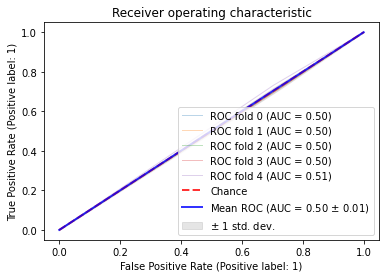

In [72]:
fpr, tpr, auc = crossvalidate_roc(X_train_pca, y_tr + y_val, clf_baseline, 5)
roc['baseline'] = [fpr,tpr,auc]

### Naive Bayes Classifier

In [73]:
clf_naive = GaussianNB()

In [74]:
scoring = ['precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
scores = cross_validate(clf_naive, X_train_pca, y_tr+y_val, scoring=scoring, cv=5)
for key, value in scores.items():
    print(key, value.mean(), value.std())

fit_time 0.02661294937133789 0.004555149202519588
score_time 0.02212233543395996 0.00398860833237127
test_precision_weighted 0.8088185982680329 0.013900818993704864
test_recall_weighted 0.7867951463240542 0.02469664525339045
test_f1_weighted 0.7934332275808308 0.02117198761009825
test_roc_auc 0.8579107459608677 0.02342973389779366


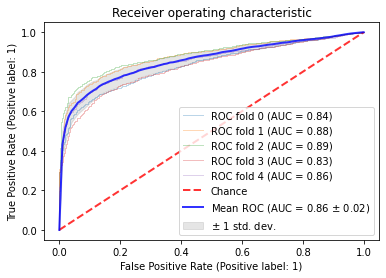

In [75]:
fpr, tpr, auc = crossvalidate_roc(X_train_pca, y_tr + y_val, clf_naive, 5)
roc['naive'] = [fpr,tpr,auc]

### Decision Tree Classifier

In [76]:
clf_dtree = tree.DecisionTreeClassifier()

In [77]:
scoring = ['precision_weighted', 'recall_weighted', 'f1_weighted','roc_auc']
scores = cross_validate(clf_dtree, X_train_pca, y_tr+y_val, scoring=scoring, cv=5)
for key, value in scores.items():
    print(key, value.mean(), value.std())

fit_time 2.8393211364746094 0.11583895706930036
score_time 0.009576511383056641 0.0032447074149382833
test_precision_weighted 0.8481662021799771 0.00740652728357399
test_recall_weighted 0.8479657387580299 0.005789949975923847
test_f1_weighted 0.8477996674691874 0.0063741147502118425
test_roc_auc 0.8034587644553991 0.014193125198338373


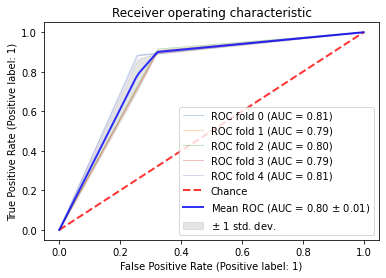

In [78]:
fpr, tpr, auc = crossvalidate_roc(X_train_pca, y_tr + y_val, clf_dtree, 5)
roc['decision tree'] = [fpr,tpr,auc]

### Random Forest Classifier

In [79]:
clf_randomforest = RandomForestClassifier(max_depth=2, random_state=0)

In [80]:
scoring = ['precision_weighted', 'recall_weighted', 'f1_weighted','roc_auc']
scores = cross_validate(clf_randomforest, X_train_pca, y_tr+y_val, scoring=scoring, cv=5)
for key, value in scores.items():
    print(key, value.mean(), value.std())

c:\miniconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\miniconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\miniconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\miniconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1245

fit_time 1.824109935760498 0.07163345561439484
score_time 0.04975800514221192 0.0009536443514884722
test_precision_weighted 0.5432353050563965 0.00021046453512099105
test_recall_weighted 0.7370449678800857 0.0001427551748751199
test_f1_weighted 0.6254706141470875 0.00019089835432009039
test_roc_auc 0.9039695756651149 0.01018797835293431


c:\miniconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


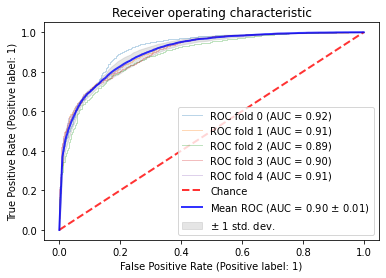

In [81]:
fpr, tpr, auc = crossvalidate_roc(X_train_pca, y_tr + y_val, clf_randomforest, 5)
roc['random forest'] = [fpr,tpr,auc]

### Support Vector Machine

In [82]:
clf_svm = svm.SVC()

In [83]:
scoring = ['precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
scores = cross_validate(clf_svm, X_train_pca, y_tr+y_val, scoring=scoring, cv=5)
for key, value in scores.items():
    print(key, value.mean(), value.std())

fit_time 5.192263221740722 0.3822287292960816
score_time 2.9134644985198976 0.05112612851206465
test_precision_weighted 0.9630466014733825 0.005715361870244956
test_recall_weighted 0.9630977872947895 0.005703958036832864
test_f1_weighted 0.9628444220430131 0.005915931150023804
test_roc_auc 0.9920925652697065 0.0010701567263121255


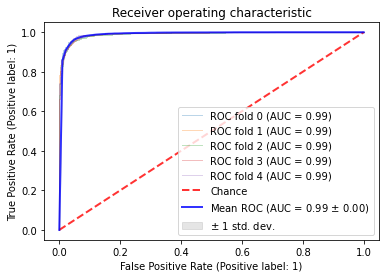

In [84]:
fpr, tpr, auc = crossvalidate_roc(X_train_pca, y_tr + y_val, clf_svm, 5)
roc['support vector machine'] = [fpr,tpr,auc]

### Plot combined ROC curves

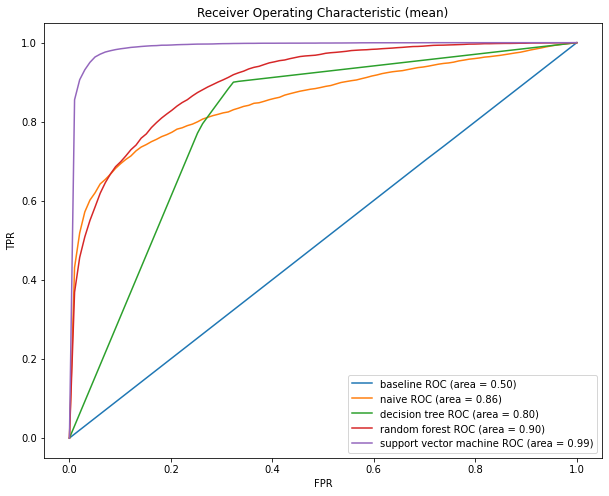

In [85]:
plt.figure(figsize=(10,8))
for key, value in roc.items():
    plt.plot(value[0], value[1], label='%s ROC (area = %0.2f)' % (key, value[2]))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic (mean)')
plt.show()

### Model Selected - Support Vector Machine

From the above we can see that the model based on Support Vector Machine had the best performance on the validation set.  We will choose this model, perform hyper parameter tuning and then make a final evaluation on the test set.

## Hyperparameter tuning

In [86]:
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'rbf'), 'C':[0.5, 1.0, 1.5, 1.75, 2, 2.25, 2.5, 5, 10]}
clf_ = GridSearchCV(svm.SVC(class_weight='balanced'), parameters, cv=5)
search = clf_.fit(X_train_pca, y_tr + y_val)
print(search.best_params_)

{'C': 10, 'kernel': 'rbf'}


### Evaluate Final Model on Test Set

In [87]:
clf_svm_final = svm.SVC(C=search.best_params_['C'], kernel=search.best_params_['kernel'], class_weight='balanced')

In [88]:
clf_svm_final.fit(X_train_pca, y_tr + y_val)

SVC(C=10, class_weight='balanced')

In [89]:
#p = np.array(clf_svm_final.decision_function(x_test))
#prob = np.exp(p)/np.sum(np.exp(p), keepdims=True)
pred_svm_final = clf_svm.predict(X_test_pca)
print(classification_report(y_test_img, pred_svm_final))

              precision    recall  f1-score   support

           0       0.95      0.57      0.72       353
           1       0.82      0.99      0.90       707

    accuracy                           0.85      1060
   macro avg       0.89      0.78      0.81      1060
weighted avg       0.87      0.85      0.84      1060



confusion matrix
[[202 151]
 [ 10 697]]


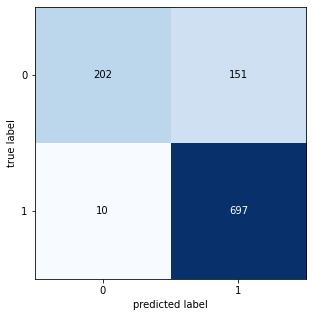

In [90]:
#CM_svm_final = confusion_matrix(test_set.classes, np.argmax(pred_svm_final, axis=1))
CM_svm_final = confusion_matrix(y_test_img, pred_svm_final)
print("confusion matrix")
print(CM_svm_final)
fig, ax = plot_confusion_matrix(conf_mat=CM_svm_final ,  figsize=(5, 5))
plt.show()

## Deep Neural Nets

### Define Metrics

In [91]:
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]

### Define Cross validation function

In [92]:
def kfoldcrossval(x, y, folds, epochs, batchsize, model):
    
    losses = {}
    val_losses = {}
    accuracies = {}
    val_accuracies = {}
    
    val_auc = [] # validation auc for each fold
    val_recall = [] # validation recall for each fold
    val_precision = [] # validation precision for each fold
    
    skf = StratifiedKFold(n_splits=folds, random_state=0, shuffle=True)
    for train, test in tqdm(skf.split(x,y)):
        #print("TRAIN:", train, "TeST: ", test)
        
        train_x = list();
        train_y = list();
        test_x = list();
        test_y = list();
        
        for train_index in train:
            train_x.append(x[train_index])
            train_y.append(y[train_index])
        
        for test_index in test:
            test_x.append(x[test_index])
            test_y.append(y[test_index])            
        
        with tf.device(device_spec):
            history = model.fit(np.array(train_x), np.array(train_y), batch_size=batchsize, epochs=epochs, class_weight=class_weight, validation_data=(np.array(test_x), np.array(test_y)), verbose=1)
        
            # getting the very last epoch value for each of these
            val_auc.append(history.history['val_auc'][len(history.history['val_auc']) - 1])
            val_recall.append(history.history['val_recall'][len(history.history['val_recall']) - 1])
            val_precision.append(history.history['val_precision'][len(history.history['val_precision']) - 1])
            
            # getting all epoch values so that we can plot them later 
            history_df = pd.DataFrame(history.history)
            for i in range(0, len(history_df)):

                if i in losses:
                    losses[i].append(history_df['loss'][i])
                else:
                    losses[i] = []
                    losses[i].append(history_df['loss'][i])

                if i in val_losses:
                    val_losses[i].append(history_df['val_loss'][i])
                else:
                    val_losses[i] = []
                    val_losses[i].append(history_df['val_loss'][i])

                if i in accuracies:
                    accuracies[i].append(history_df['accuracy'][i])
                else:
                    accuracies[i] = []
                    accuracies[i].append(history_df['accuracy'][i])

                if i in val_accuracies:
                    val_accuracies[i].append(history_df['val_accuracy'][i])
                else:
                    val_accuracies[i] = []
                    val_accuracies[i].append(history_df['val_accuracy'][i])                
        
    return losses, val_losses, accuracies, val_accuracies, val_auc, val_recall, val_precision


### Building CNN-0

In [113]:
cnn_0 = tf.keras.models.Sequential(name='cnn_0')

# convolution and pooling
cnn_0.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(128,128, 1) ))
cnn_0.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding = 'same'))
cnn_0.add(tf.keras.layers.Dropout(0.1))

# flattenning
cnn_0.add(tf.keras.layers.Flatten())

# full connection
# units = number of hidden neurons - larger number better for images
cnn_0.add(tf.keras.layers.Dense(units=256, activation='relu'))

# dropout
cnn_0.add(tf.keras.layers.Dropout(0.5))

# output layer
cnn_0.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# compiling and summary
optimizer = tf.keras.optimizers.Adam(lr=0.0005)
cnn_0.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=METRICS)
cnn_0.summary()

  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)

Model: "cnn_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 64)      640       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 63, 63, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 254016)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65028352  
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
________________________________________________________

# Building CNN-1

In [94]:
cnn_1 = tf.keras.models.Sequential(name='cnn_1')

# Convolution and Pooling
cnn_1.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(128,128, 1) ))
cnn_1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding = 'same'))
cnn_1.add(tf.keras.layers.Dropout(0.1))

cnn_1.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu'))
cnn_1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding = 'same'))
cnn_1.add(tf.keras.layers.Dropout(0.25))

cnn_1.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu'))
cnn_1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding = 'same'))
cnn_1.add(tf.keras.layers.Dropout(0.25))

# flatten
cnn_1.add(tf.keras.layers.Flatten())

# full connection
cnn_1.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.001)))

# dropout
cnn_1.add(tf.keras.layers.Dropout(0.5))

# output layer
# units = 1 for binary classification
cnn_1.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# compi;ing and summary
cnn_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
cnn_1.summary()

  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)

Model: "cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 31, 31, 32)        0         
________________________________________________________

### Building CNN-2

In [114]:
cnn_2 = tf.keras.models.Sequential(name='cnn_2')

cnn_2.add(tf.keras.layers.Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', input_shape=(128,128,1) ))

cnn_2.add(tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
cnn_2.add(tf.keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn_2.add(tf.keras.layers.Dropout(0.1))

cnn_2.add(tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
cnn_2.add(tf.keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn_2.add(tf.keras.layers.Dropout(0.1))

cnn_2.add(tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
cnn_2.add(tf.keras.layers.Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn_2.add(tf.keras.layers.Dropout(0.3))

cnn_2.add(tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
cnn_2.add(tf.keras.layers.Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn_2.add(tf.keras.layers.Dropout(0.3))

cnn_2.add(tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
cnn_2.add(tf.keras.layers.Flatten())

cnn_2.add(tf.keras.layers.Dense(units = 256 , activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.007)))
cnn_2.add(tf.keras.layers.Dropout(0.5))

a = tf.keras.layers.Activation('sigmoid', dtype='float32', name='predictions')
cnn_2.add(tf.keras.layers.Dense(units = 1 , activation = a))
cnn_2.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = METRICS)
cnn_2.summary()

  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)

Model: "cnn_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 64)        36928     
________________________________________________________

In [96]:
# reshape the images to fit the input  layers

In [97]:
# training images
xtr = [resize(img, (128,128,1)) for img in x_train_img]
# validation images
xval = [resize(img, (128,128,1)) for img in x_val_img]

## Training

In [98]:

num_folds = 5


#### 3.0 Training CNN-0

In [99]:
num_epochs = 25
num_batchsize = 64

losses_0, val_losses_0, accuracies_0, val_accuracies_0, val_auc_0, val_recall_0, val_precision_0 = kfoldcrossval(xtr + xval, y_tr + y_val, num_folds, num_epochs, num_batchsize, cnn_0)

0it [00:00, ?it/s]

Epoch 1/25
176/176 [==============================] - 20s 45ms/step - loss: 1.4582 - accuracy: 0.7134 - precision: 0.8681 - recall: 0.7143 - auc: 0.7327 - val_loss: 0.1334 - val_accuracy: 0.9532 - val_precision: 0.9740 - val_recall: 0.9622 - val_auc: 0.9882
Epoch 2/25
176/176 [==============================] - 7s 40ms/step - loss: 0.1588 - accuracy: 0.9374 - precision: 0.9778 - recall: 0.9361 - auc: 0.9856 - val_loss: 0.1566 - val_accuracy: 0.9411 - val_precision: 0.9933 - val_recall: 0.9264 - val_auc: 0.9924
Epoch 3/25
176/176 [==============================] - 7s 41ms/step - loss: 0.1346 - accuracy: 0.9488 - precision: 0.9838 - recall: 0.9454 - auc: 0.9891 - val_loss: 0.1035 - val_accuracy: 0.9625 - val_precision: 0.9734 - val_recall: 0.9758 - val_auc: 0.9921
Epoch 4/25
176/176 [==============================] - 7s 39ms/step - loss: 0.1248 - accuracy: 0.9488 - precision: 0.9823 - recall: 0.9468 - auc: 0.9908 - val_loss: 0.1024 - val_accuracy: 0.9615 - val_precision: 0.9847 - val_reca

1it [03:06, 186.12s/it]

Epoch 1/25
176/176 [==============================] - 7s 39ms/step - loss: 0.0471 - accuracy: 0.9841 - precision: 0.9952 - recall: 0.9832 - auc: 0.9976 - val_loss: 0.0194 - val_accuracy: 0.9939 - val_precision: 0.9990 - val_recall: 0.9927 - val_auc: 1.0000
Epoch 2/25
176/176 [==============================] - 7s 38ms/step - loss: 0.0368 - accuracy: 0.9885 - precision: 0.9966 - recall: 0.9878 - auc: 0.9987 - val_loss: 0.0131 - val_accuracy: 0.9975 - val_precision: 0.9981 - val_recall: 0.9985 - val_auc: 0.9999
Epoch 3/25
176/176 [==============================] - 7s 38ms/step - loss: 0.0255 - accuracy: 0.9918 - precision: 0.9973 - recall: 0.9915 - auc: 0.9993 - val_loss: 0.0100 - val_accuracy: 0.9975 - val_precision: 1.0000 - val_recall: 0.9966 - val_auc: 1.0000
Epoch 4/25
176/176 [==============================] - 7s 38ms/step - loss: 0.0207 - accuracy: 0.9932 - precision: 0.9982 - recall: 0.9926 - auc: 0.9996 - val_loss: 0.0226 - val_accuracy: 0.9914 - val_precision: 1.0000 - val_recal

2it [05:56, 176.95s/it]

Epoch 1/25
176/176 [==============================] - 7s 39ms/step - loss: 0.0299 - accuracy: 0.9900 - precision: 0.9965 - recall: 0.9900 - auc: 0.9991 - val_loss: 0.0030 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 2/25
176/176 [==============================] - 7s 38ms/step - loss: 0.0125 - accuracy: 0.9962 - precision: 0.9991 - recall: 0.9956 - auc: 0.9999 - val_loss: 0.0018 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 3/25
176/176 [==============================] - 7s 38ms/step - loss: 0.0117 - accuracy: 0.9959 - precision: 0.9988 - recall: 0.9956 - auc: 0.9999 - val_loss: 0.0035 - val_accuracy: 0.9996 - val_precision: 1.0000 - val_recall: 0.9995 - val_auc: 1.0000
Epoch 4/25
176/176 [==============================] - 7s 38ms/step - loss: 0.0093 - accuracy: 0.9971 - precision: 0.9992 - recall: 0.9969 - auc: 0.9999 - val_loss: 0.0019 - val_accuracy: 0.9996 - val_precision: 0.9995 - val_recal

3it [08:43, 172.34s/it]

Epoch 1/25
176/176 [==============================] - 7s 38ms/step - loss: 0.0213 - accuracy: 0.9930 - precision: 0.9972 - recall: 0.9933 - auc: 0.9995 - val_loss: 0.0015 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 2/25
176/176 [==============================] - 7s 38ms/step - loss: 0.0113 - accuracy: 0.9954 - precision: 0.9984 - recall: 0.9953 - auc: 0.9999 - val_loss: 0.0017 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 3/25
176/176 [==============================] - 7s 38ms/step - loss: 0.0050 - accuracy: 0.9984 - precision: 0.9994 - recall: 0.9984 - auc: 0.9999 - val_loss: 4.4133e-04 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 4/25
176/176 [==============================] - 7s 38ms/step - loss: 0.0017 - accuracy: 0.9998 - precision: 1.0000 - recall: 0.9998 - auc: 1.0000 - val_loss: 4.8275e-04 - val_accuracy: 1.0000 - val_precision: 1.0000 - v

4it [11:30, 170.17s/it]

Epoch 1/25
176/176 [==============================] - 7s 39ms/step - loss: 0.0078 - accuracy: 0.9978 - precision: 0.9993 - recall: 0.9977 - auc: 0.9997 - val_loss: 7.1867e-04 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 2/25
176/176 [==============================] - 7s 38ms/step - loss: 0.0080 - accuracy: 0.9982 - precision: 0.9994 - recall: 0.9982 - auc: 0.9998 - val_loss: 0.0145 - val_accuracy: 0.9939 - val_precision: 1.0000 - val_recall: 0.9918 - val_auc: 1.0000
Epoch 3/25
176/176 [==============================] - 7s 38ms/step - loss: 0.0045 - accuracy: 0.9983 - precision: 0.9996 - recall: 0.9981 - auc: 1.0000 - val_loss: 5.5499e-04 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 4/25
176/176 [==============================] - 7s 38ms/step - loss: 0.0018 - accuracy: 0.9994 - precision: 1.0000 - recall: 0.9992 - auc: 1.0000 - val_loss: 1.2303e-04 - val_accuracy: 1.0000 - val_precision: 1.0000

5it [14:20, 172.17s/it]


#### 3.1 Training CNN-1

In [100]:
# NOTE - cannot use the validation_split when using data set generators so need to split the dataframe manually
# into train and validation set. This was done above

losses_1, val_losses_1, accuracies_1, val_accuracies_1, val_auc_1,  val_recall_1, val_precision_1 = kfoldcrossval(xtr + xval, y_tr + y_val, num_folds, num_epochs, num_batchsize, cnn_1)

0it [00:00, ?it/s]

Epoch 1/25
176/176 [==============================] - 8s 35ms/step - loss: 0.9363 - accuracy: 0.6607 - precision: 0.9121 - recall: 0.8198 - auc: 0.9000 - val_loss: 0.2943 - val_accuracy: 0.9051 - val_precision: 0.9712 - val_recall: 0.8979 - val_auc: 0.9765
Epoch 2/25
176/176 [==============================] - 6s 32ms/step - loss: 0.3036 - accuracy: 0.9029 - precision: 0.9661 - recall: 0.8994 - auc: 0.9647 - val_loss: 0.2531 - val_accuracy: 0.9172 - val_precision: 0.9857 - val_recall: 0.9008 - val_auc: 0.9839
Epoch 3/25
176/176 [==============================] - 6s 32ms/step - loss: 0.2626 - accuracy: 0.9156 - precision: 0.9719 - recall: 0.9120 - auc: 0.9733 - val_loss: 0.1876 - val_accuracy: 0.9479 - val_precision: 0.9598 - val_recall: 0.9700 - val_auc: 0.9866
Epoch 4/25
176/176 [==============================] - 6s 33ms/step - loss: 0.2418 - accuracy: 0.9261 - precision: 0.9754 - recall: 0.9230 - auc: 0.9785 - val_loss: 0.1893 - val_accuracy: 0.9561 - val_precision: 0.9798 - val_recal

1it [02:38, 158.58s/it]

Epoch 1/25
176/176 [==============================] - 7s 37ms/step - loss: 0.1412 - accuracy: 0.9702 - precision: 0.9910 - recall: 0.9684 - auc: 0.9955 - val_loss: 0.1266 - val_accuracy: 0.9768 - val_precision: 0.9975 - val_recall: 0.9709 - val_auc: 0.9985
Epoch 2/25
176/176 [==============================] - 6s 37ms/step - loss: 0.1450 - accuracy: 0.9679 - precision: 0.9887 - recall: 0.9674 - auc: 0.9951 - val_loss: 0.1148 - val_accuracy: 0.9804 - val_precision: 0.9922 - val_recall: 0.9811 - val_auc: 0.9981
Epoch 3/25
176/176 [==============================] - 6s 37ms/step - loss: 0.1378 - accuracy: 0.9717 - precision: 0.9911 - recall: 0.9703 - auc: 0.9959 - val_loss: 0.1479 - val_accuracy: 0.9682 - val_precision: 0.9970 - val_recall: 0.9598 - val_auc: 0.9975
Epoch 4/25
176/176 [==============================] - 7s 38ms/step - loss: 0.1389 - accuracy: 0.9696 - precision: 0.9905 - recall: 0.9680 - auc: 0.9960 - val_loss: 0.1364 - val_accuracy: 0.9739 - val_precision: 0.9931 - val_recal

2it [05:20, 160.69s/it]

Epoch 1/25
176/176 [==============================] - 6s 37ms/step - loss: 0.1412 - accuracy: 0.9728 - precision: 0.9909 - recall: 0.9720 - auc: 0.9962 - val_loss: 0.1082 - val_accuracy: 0.9843 - val_precision: 0.9966 - val_recall: 0.9821 - val_auc: 0.9993
Epoch 2/25
176/176 [==============================] - 6s 36ms/step - loss: 0.1303 - accuracy: 0.9761 - precision: 0.9928 - recall: 0.9746 - auc: 0.9967 - val_loss: 0.1100 - val_accuracy: 0.9811 - val_precision: 0.9985 - val_recall: 0.9758 - val_auc: 0.9992
Epoch 3/25
176/176 [==============================] - 6s 36ms/step - loss: 0.1352 - accuracy: 0.9745 - precision: 0.9922 - recall: 0.9730 - auc: 0.9966 - val_loss: 0.1194 - val_accuracy: 0.9822 - val_precision: 0.9966 - val_recall: 0.9792 - val_auc: 0.9989
Epoch 4/25
176/176 [==============================] - 6s 37ms/step - loss: 0.1302 - accuracy: 0.9768 - precision: 0.9926 - recall: 0.9758 - auc: 0.9972 - val_loss: 0.1015 - val_accuracy: 0.9864 - val_precision: 0.9966 - val_recal

3it [08:01, 160.60s/it]

Epoch 1/25
176/176 [==============================] - 6s 37ms/step - loss: 0.1361 - accuracy: 0.9726 - precision: 0.9917 - recall: 0.9709 - auc: 0.9968 - val_loss: 0.1030 - val_accuracy: 0.9921 - val_precision: 0.9985 - val_recall: 0.9908 - val_auc: 0.9996
Epoch 2/25
176/176 [==============================] - 6s 36ms/step - loss: 0.1320 - accuracy: 0.9756 - precision: 0.9918 - recall: 0.9751 - auc: 0.9975 - val_loss: 0.1135 - val_accuracy: 0.9864 - val_precision: 0.9990 - val_recall: 0.9826 - val_auc: 0.9995
Epoch 3/25
176/176 [==============================] - 6s 36ms/step - loss: 0.1259 - accuracy: 0.9782 - precision: 0.9930 - recall: 0.9774 - auc: 0.9976 - val_loss: 0.0989 - val_accuracy: 0.9893 - val_precision: 0.9966 - val_recall: 0.9889 - val_auc: 0.9995
Epoch 4/25
176/176 [==============================] - 7s 37ms/step - loss: 0.1173 - accuracy: 0.9805 - precision: 0.9937 - recall: 0.9798 - auc: 0.9983 - val_loss: 0.1272 - val_accuracy: 0.9811 - val_precision: 0.9990 - val_recal

4it [10:40, 160.22s/it]

Epoch 1/25
176/176 [==============================] - 6s 36ms/step - loss: 0.1186 - accuracy: 0.9799 - precision: 0.9939 - recall: 0.9788 - auc: 0.9978 - val_loss: 0.0857 - val_accuracy: 0.9957 - val_precision: 0.9971 - val_recall: 0.9971 - val_auc: 0.9999
Epoch 2/25
176/176 [==============================] - 6s 36ms/step - loss: 0.1123 - accuracy: 0.9819 - precision: 0.9941 - recall: 0.9812 - auc: 0.9985 - val_loss: 0.0931 - val_accuracy: 0.9907 - val_precision: 0.9976 - val_recall: 0.9898 - val_auc: 0.9995
Epoch 3/25
176/176 [==============================] - 6s 36ms/step - loss: 0.1121 - accuracy: 0.9824 - precision: 0.9946 - recall: 0.9815 - auc: 0.9984 - val_loss: 0.1044 - val_accuracy: 0.9879 - val_precision: 0.9980 - val_recall: 0.9855 - val_auc: 0.9992
Epoch 4/25
176/176 [==============================] - 6s 37ms/step - loss: 0.1148 - accuracy: 0.9822 - precision: 0.9948 - recall: 0.9809 - auc: 0.9985 - val_loss: 0.1053 - val_accuracy: 0.9875 - val_precision: 0.9918 - val_recal

5it [13:24, 160.91s/it]


#### 3.2 Train CNN-2

In [101]:
#history_cnn_2 = cnn_2.fit(x = train_set, class_weight=class_weight, validation_data = validation_set, epochs=50 )

In [102]:
losses_2, val_losses_2, accuracies_2, val_accuracies_2, val_auc_2,  val_recall_2, val_precision_2  = kfoldcrossval(xtr + xval, y_tr + y_val, num_folds, num_epochs, num_batchsize, cnn_2)

0it [00:00, ?it/s]

Epoch 1/25
176/176 [==============================] - 10s 47ms/step - loss: 1.3642 - accuracy: 0.6140 - precision: 0.9302 - recall: 0.7534 - auc: 0.9055 - val_loss: 0.3468 - val_accuracy: 0.9076 - val_precision: 0.9850 - val_recall: 0.8882 - val_auc: 0.9809
Epoch 2/25
176/176 [==============================] - 7s 42ms/step - loss: 0.2601 - accuracy: 0.9162 - precision: 0.9717 - recall: 0.9126 - auc: 0.9733 - val_loss: 0.2007 - val_accuracy: 0.9515 - val_precision: 0.9811 - val_recall: 0.9526 - val_auc: 0.9890
Epoch 3/25
176/176 [==============================] - 7s 40ms/step - loss: 0.1813 - accuracy: 0.9445 - precision: 0.9810 - recall: 0.9432 - auc: 0.9877 - val_loss: 0.1718 - val_accuracy: 0.9643 - val_precision: 0.9740 - val_recall: 0.9777 - val_auc: 0.9935
Epoch 4/25
176/176 [==============================] - 7s 40ms/step - loss: 0.1443 - accuracy: 0.9609 - precision: 0.9892 - recall: 0.9578 - auc: 0.9926 - val_loss: 0.1520 - val_accuracy: 0.9647 - val_precision: 0.9920 - val_reca

1it [02:59, 179.61s/it]

Epoch 1/25
176/176 [==============================] - 7s 40ms/step - loss: 0.0709 - accuracy: 0.9832 - precision: 0.9951 - recall: 0.9821 - auc: 0.9979 - val_loss: 0.0497 - val_accuracy: 0.9950 - val_precision: 0.9981 - val_recall: 0.9952 - val_auc: 0.9998
Epoch 2/25
176/176 [==============================] - 7s 39ms/step - loss: 0.0695 - accuracy: 0.9848 - precision: 0.9956 - recall: 0.9838 - auc: 0.9985 - val_loss: 0.0481 - val_accuracy: 0.9921 - val_precision: 0.9995 - val_recall: 0.9898 - val_auc: 0.9998
Epoch 3/25
176/176 [==============================] - 7s 40ms/step - loss: 0.0613 - accuracy: 0.9852 - precision: 0.9960 - recall: 0.9839 - auc: 0.9988 - val_loss: 0.0495 - val_accuracy: 0.9964 - val_precision: 0.9971 - val_recall: 0.9981 - val_auc: 0.9998
Epoch 4/25
176/176 [==============================] - 7s 40ms/step - loss: 0.0573 - accuracy: 0.9867 - precision: 0.9967 - recall: 0.9852 - auc: 0.9988 - val_loss: 0.0485 - val_accuracy: 0.9925 - val_precision: 0.9937 - val_recal

2it [05:55, 177.54s/it]

Epoch 1/25
176/176 [==============================] - 7s 42ms/step - loss: 0.0505 - accuracy: 0.9907 - precision: 0.9971 - recall: 0.9903 - auc: 0.9989 - val_loss: 0.0539 - val_accuracy: 0.9925 - val_precision: 1.0000 - val_recall: 0.9898 - val_auc: 1.0000
Epoch 2/25
176/176 [==============================] - 7s 40ms/step - loss: 0.0509 - accuracy: 0.9903 - precision: 0.9976 - recall: 0.9892 - auc: 0.9992 - val_loss: 0.0298 - val_accuracy: 0.9993 - val_precision: 1.0000 - val_recall: 0.9990 - val_auc: 1.0000
Epoch 3/25
176/176 [==============================] - 7s 40ms/step - loss: 0.0337 - accuracy: 0.9944 - precision: 0.9984 - recall: 0.9939 - auc: 0.9997 - val_loss: 0.0253 - val_accuracy: 0.9989 - val_precision: 0.9995 - val_recall: 0.9990 - val_auc: 1.0000
Epoch 4/25
176/176 [==============================] - 7s 40ms/step - loss: 0.0359 - accuracy: 0.9932 - precision: 0.9982 - recall: 0.9926 - auc: 0.9997 - val_loss: 0.0333 - val_accuracy: 0.9979 - val_precision: 0.9985 - val_recal

3it [08:53, 177.47s/it]

Epoch 1/25
176/176 [==============================] - 7s 40ms/step - loss: 0.0395 - accuracy: 0.9936 - precision: 0.9983 - recall: 0.9930 - auc: 0.9993 - val_loss: 0.0238 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 2/25
176/176 [==============================] - 7s 40ms/step - loss: 0.0420 - accuracy: 0.9923 - precision: 0.9976 - recall: 0.9920 - auc: 0.9995 - val_loss: 0.0213 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 3/25
176/176 [==============================] - 7s 40ms/step - loss: 0.0328 - accuracy: 0.9956 - precision: 0.9987 - recall: 0.9954 - auc: 0.9995 - val_loss: 0.0284 - val_accuracy: 0.9982 - val_precision: 1.0000 - val_recall: 0.9976 - val_auc: 1.0000
Epoch 4/25
176/176 [==============================] - 7s 40ms/step - loss: 0.0353 - accuracy: 0.9944 - precision: 0.9982 - recall: 0.9942 - auc: 0.9995 - val_loss: 0.0408 - val_accuracy: 0.9964 - val_precision: 0.9957 - val_recal

4it [11:49, 177.20s/it]

Epoch 1/25
176/176 [==============================] - 7s 41ms/step - loss: 0.0280 - accuracy: 0.9954 - precision: 0.9985 - recall: 0.9953 - auc: 0.9999 - val_loss: 0.0209 - val_accuracy: 0.9996 - val_precision: 1.0000 - val_recall: 0.9995 - val_auc: 1.0000
Epoch 2/25
176/176 [==============================] - 7s 40ms/step - loss: 0.0298 - accuracy: 0.9956 - precision: 0.9989 - recall: 0.9952 - auc: 0.9998 - val_loss: 0.0375 - val_accuracy: 0.9957 - val_precision: 0.9957 - val_recall: 0.9985 - val_auc: 0.9999
Epoch 3/25
176/176 [==============================] - 7s 40ms/step - loss: 0.0378 - accuracy: 0.9946 - precision: 0.9982 - recall: 0.9946 - auc: 0.9995 - val_loss: 0.0318 - val_accuracy: 0.9971 - val_precision: 1.0000 - val_recall: 0.9961 - val_auc: 1.0000
Epoch 4/25
176/176 [==============================] - 7s 40ms/step - loss: 0.0343 - accuracy: 0.9963 - precision: 0.9988 - recall: 0.9962 - auc: 0.9995 - val_loss: 0.0189 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recal

5it [14:48, 177.61s/it]


### Evaluating

#### 1. Examine the loss and accuracy curves

In [103]:
def getAverages(losses, val_losses, accuracies, val_accuracies):
    avg_losses = []
    max_losses = []
    avg_val_losses = []

    for i in range(len(losses)):
        avg_losses.append(statistics.mean(losses[i]))
        max_losses.append(max(losses[i]))
        avg_val_losses.append(statistics.mean(val_losses[i])) 

    avg_accuracies = []
    avg_val_accuracies = []

    for i in range(len(accuracies)):
        avg_accuracies.append(statistics.mean(accuracies[i]))
        avg_val_accuracies.append(statistics.mean(val_accuracies[i])) 
    
    return avg_losses, avg_val_losses, avg_accuracies, avg_val_accuracies

In [104]:
def plotLossAccuracyCurves(avg_losses, avg_val_losses, avg_accuracies, avg_val_accuracies):
    plt.figure(figsize=(20,5))
    
    e = [i for i in range(len(avg_losses))]

    # plot loss & val loss
    plt.subplot(1,2,1)
    sns.lineplot(x=e, y=avg_losses, color='red', label='avg train Loss')
    sns.lineplot(x=e, y=avg_val_losses, color='orange', label='avg val Loss')
    plt.title('avg Loss on train vs validation')
    plt.legend(loc='best')

    # plot accuracy and val accuracy
    plt.subplot(1,2,2)
    sns.lineplot(x=e, y=avg_accuracies, color='blue', label='avg Train Accuracy')
    sns.lineplot(x=e, y=avg_val_accuracies, color='green', label='avg Val Accuracy')
    plt.title('avg Accuracy on train vs validation')
    plt.legend(loc='best')

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

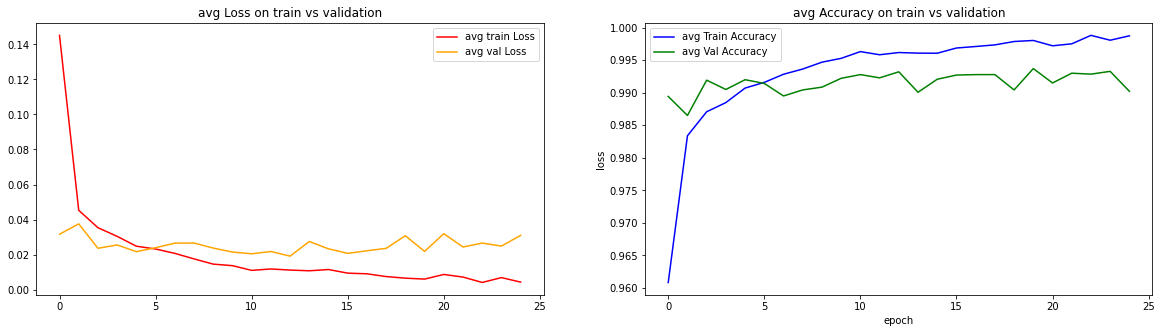

In [105]:
l, vl, a, va = getAverages(losses_0, val_losses_0, accuracies_0, val_accuracies_0)
plotLossAccuracyCurves(l, vl, a, va)

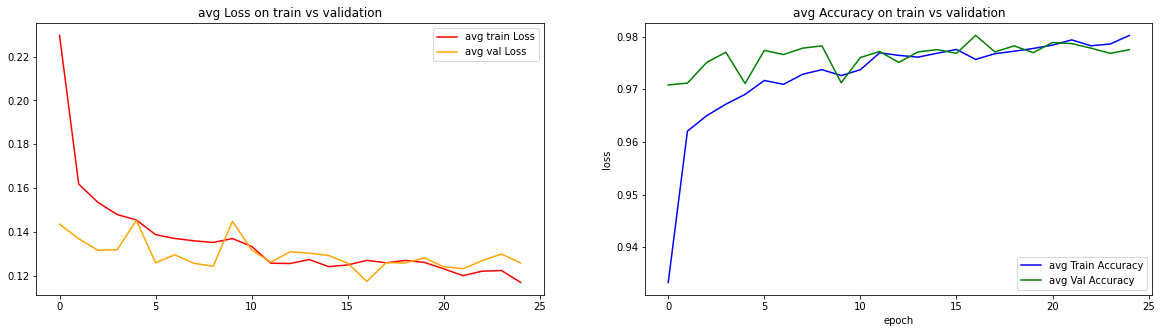

In [106]:
l, vl, a, va = getAverages(losses_1, val_losses_1, accuracies_1, val_accuracies_1)
plotLossAccuracyCurves(l, vl, a, va)

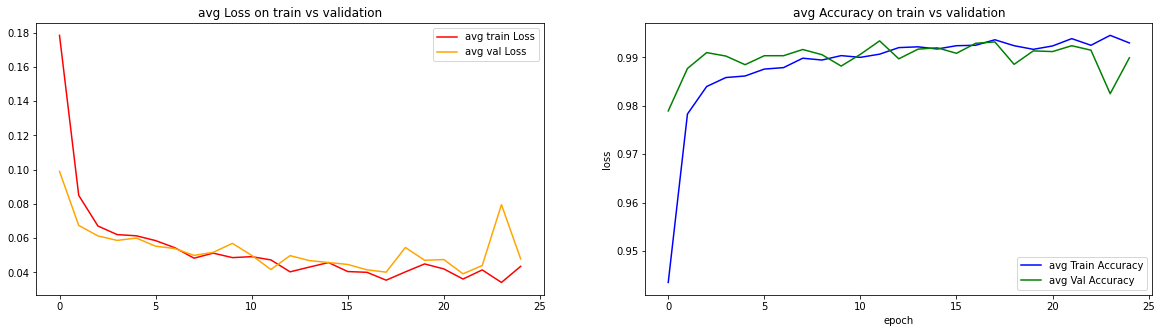

In [107]:
l, vl, a, va = getAverages(losses_2, val_losses_2, accuracies_2, val_accuracies_2)
plotLossAccuracyCurves(l, vl, a, va)

#### 1.2 AUC Values

In [108]:
# cnn_0 avg val auc 
print("mean val_auc_0: " , statistics.mean(val_auc_0))

# cnn_1 avg val auc 
print("mean val_auc_1: " , statistics.mean(val_auc_1))

# cnn_2 avg val auc
print("mean val_auc_2: " , statistics.mean(val_auc_2))


mean val_auc_0:  0.9980436205863953
mean val_auc_1:  0.9976649284362793
mean val_auc_2:  0.9994647979736329


#### 1.3 Recall, Precision and F1 Scores

In [109]:
# recall
# cnn_0 avg val recall 
print("mean val_recall_0: " , statistics.mean(val_recall_0))
# cnn_1 avg val recall
print("mean val_recall_1: " , statistics.mean(val_recall_1))
# cnn_2 avg val recall
print("mean val_recall_2: " , statistics.mean(val_recall_2))

# precision
# cnn_0 avg val precision 
print("mean val_precision_0: " , statistics.mean(val_precision_0))
# cnn_1 avg val precision
print("mean val_precision_1: " , statistics.mean(val_precision_1))
# cnn_2 avg val precision
print("mean val_precision_2: " , statistics.mean(val_precision_2))

mean val_recall_0:  0.9913818836212158
mean val_recall_1:  0.9750159978866577
mean val_recall_2:  0.9907038092613221
mean val_precision_0:  0.9953516483306885
mean val_precision_1:  0.9943637609481811
mean val_precision_2:  0.995637571811676


In [110]:
def f1(recall, precision):
    return 2 * (precision * recall) / (precision + recall) 

In [111]:
print("f1 cnn_0: " + str(f1(statistics.mean(val_recall_0), statistics.mean(val_precision_0))))
print("f1 cnn_1: " + str(f1(statistics.mean(val_recall_1), statistics.mean(val_precision_1))))
print("f1 cnn_2: " + str(f1(statistics.mean(val_recall_2), statistics.mean(val_precision_2))))

f1 cnn_0: 0.9933627999101473
f1 cnn_1: 0.9845948403743385
f1 cnn_2: 0.9931645631877122


### Model Selection / Final Training

Selection CNN-2 and CNN-0 based on the above performance.  CNN-2 slightly less overfitting, does better overall on both classes. AUC of CNN-2 is higher. Although F1 of CNN-0 is higher.  WIll evaluate both on test set to make final selection.

Train on all the data (except test set)

NOTE: I have to clear the models first by rebuilding them from above

In [115]:
history = cnn_2.fit(np.array(xtr + xval), np.array(y_tr + y_val), batch_size=64, epochs=50, class_weight=class_weight, validation_data=(np.array(x_test_img).reshape(1060, 128, 128,1), np.array(y_test_img)), verbose=1)

Epoch 1/50
219/219 [==============================] - 10s 40ms/step - loss: 1.2468 - accuracy: 0.6079 - precision: 0.9582 - recall: 0.8448 - auc: 0.9625 - val_loss: 0.3932 - val_accuracy: 0.8500 - val_precision: 0.8350 - val_recall: 0.9661 - val_auc: 0.9359
Epoch 2/50
219/219 [==============================] - 8s 38ms/step - loss: 0.2309 - accuracy: 0.9321 - precision: 0.9774 - recall: 0.9297 - auc: 0.9788 - val_loss: 0.3481 - val_accuracy: 0.8604 - val_precision: 0.8446 - val_recall: 0.9689 - val_auc: 0.9488
Epoch 3/50
219/219 [==============================] - 8s 38ms/step - loss: 0.1790 - accuracy: 0.9463 - precision: 0.9839 - recall: 0.9421 - auc: 0.9880 - val_loss: 0.3916 - val_accuracy: 0.8623 - val_precision: 0.8335 - val_recall: 0.9915 - val_auc: 0.9311
Epoch 4/50
219/219 [==============================] - 8s 37ms/step - loss: 0.1618 - accuracy: 0.9558 - precision: 0.9853 - recall: 0.9547 - auc: 0.9894 - val_loss: 0.4422 - val_accuracy: 0.8566 - val_precision: 0.8292 - val_reca

Epoch 33/50
219/219 [==============================] - 8s 37ms/step - loss: 0.0485 - accuracy: 0.9901 - precision: 0.9971 - recall: 0.9894 - auc: 0.9995 - val_loss: 0.8320 - val_accuracy: 0.8566 - val_precision: 0.8261 - val_recall: 0.9943 - val_auc: 0.8945
Epoch 34/50
219/219 [==============================] - 8s 38ms/step - loss: 0.0418 - accuracy: 0.9928 - precision: 0.9983 - recall: 0.9919 - auc: 0.9996 - val_loss: 0.8448 - val_accuracy: 0.8585 - val_precision: 0.8273 - val_recall: 0.9958 - val_auc: 0.8984
Epoch 35/50
219/219 [==============================] - 8s 38ms/step - loss: 0.0497 - accuracy: 0.9905 - precision: 0.9969 - recall: 0.9901 - auc: 0.9993 - val_loss: 1.0095 - val_accuracy: 0.8585 - val_precision: 0.8288 - val_recall: 0.9929 - val_auc: 0.8868
Epoch 36/50
219/219 [==============================] - 8s 38ms/step - loss: 0.0560 - accuracy: 0.9902 - precision: 0.9975 - recall: 0.9894 - auc: 0.9991 - val_loss: 0.4327 - val_accuracy: 0.9132 - val_precision: 0.8927 - val_r

In [116]:
history = cnn_0.fit(np.array(xtr + xval), np.array(y_tr + y_val), batch_size=64, epochs=50, class_weight=class_weight, validation_data=(np.array(x_test_img).reshape(1060, 128, 128,1), np.array(y_test_img)), verbose=1)

Epoch 1/50
219/219 [==============================] - 10s 41ms/step - loss: 1.4035 - accuracy: 0.7447 - precision: 0.8844 - recall: 0.8086 - auc: 0.7985 - val_loss: 0.3922 - val_accuracy: 0.8236 - val_precision: 0.7989 - val_recall: 0.9830 - val_auc: 0.9386
Epoch 2/50
219/219 [==============================] - 9s 40ms/step - loss: 0.2005 - accuracy: 0.9258 - precision: 0.9714 - recall: 0.9267 - auc: 0.9759 - val_loss: 0.3500 - val_accuracy: 0.8528 - val_precision: 0.8414 - val_recall: 0.9604 - val_auc: 0.9401
Epoch 3/50
219/219 [==============================] - 9s 40ms/step - loss: 0.1594 - accuracy: 0.9422 - precision: 0.9796 - recall: 0.9410 - auc: 0.9843 - val_loss: 0.3127 - val_accuracy: 0.8840 - val_precision: 0.8946 - val_recall: 0.9364 - val_auc: 0.9401
Epoch 4/50
219/219 [==============================] - 9s 40ms/step - loss: 0.1238 - accuracy: 0.9554 - precision: 0.9851 - recall: 0.9544 - auc: 0.9905 - val_loss: 0.3256 - val_accuracy: 0.8642 - val_precision: 0.8604 - val_reca

219/219 [==============================] - 8s 38ms/step - loss: 0.0141 - accuracy: 0.9950 - precision: 0.9987 - recall: 0.9946 - auc: 0.9999 - val_loss: 1.1981 - val_accuracy: 0.8642 - val_precision: 0.8396 - val_recall: 0.9844 - val_auc: 0.8688
Epoch 33/50
219/219 [==============================] - 8s 38ms/step - loss: 0.0138 - accuracy: 0.9951 - precision: 0.9983 - recall: 0.9951 - auc: 0.9999 - val_loss: 1.7357 - val_accuracy: 0.8321 - val_precision: 0.8016 - val_recall: 0.9943 - val_auc: 0.8231
Epoch 34/50
219/219 [==============================] - 8s 39ms/step - loss: 0.0098 - accuracy: 0.9968 - precision: 0.9987 - recall: 0.9969 - auc: 1.0000 - val_loss: 1.1897 - val_accuracy: 0.8613 - val_precision: 0.8365 - val_recall: 0.9844 - val_auc: 0.8678
Epoch 35/50
219/219 [==============================] - 8s 38ms/step - loss: 0.0137 - accuracy: 0.9949 - precision: 0.9986 - recall: 0.9944 - auc: 0.9999 - val_loss: 1.2554 - val_accuracy: 0.8642 - val_precision: 0.8404 - val_recall: 0.983

In [117]:
t = np.array(x_test_img).reshape(1060, 128, 128,1)
t = t.reshape(1060, 128, 128,1)
t.shape

(1060, 128, 128, 1)

In [118]:
y_test = np.array(y_test_img)
y_test.shape

(1060,)

In [119]:
test_labels = y_test_img

#### 2.2 Evaluate performance of CNN-0 model on Test Set

In [120]:
print("cnn0 metrics on test set")
test_accu = cnn_0.evaluate(t, np.array(y_test_img))
print(test_accu)

cnn0 metrics on test set
34/34 [==============================] - 0s 10ms/step - loss: 1.5665 - accuracy: 0.8557 - precision: 0.8259 - recall: 0.9929 - auc: 0.8408  
[1.5665258169174194, 0.8556603789329529, 0.8258823752403259, 0.9929278492927551, 0.8407787680625916]


predicting...
34/34 [==============================] - 0s 5ms/step
number of predictions  1060
classification report
              precision    recall  f1-score   support

           0       0.98      0.58      0.73       353
           1       0.83      0.99      0.90       707

    accuracy                           0.86      1060
   macro avg       0.90      0.79      0.81      1060
weighted avg       0.88      0.86      0.84      1060

confusion matrix
[[205 148]
 [  5 702]]


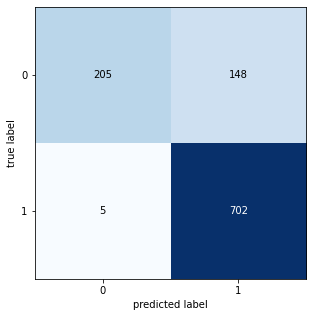

In [121]:
print("predicting...")
predictions_cnn_0 = (cnn_0.predict(t, verbose=1) > 0.5).astype("int32")
print("number of predictions ", len(predictions_cnn_0))

# get the class with highest probability for each sample
#y_pred = (predictions > 0.5).astype("int32")

# get the classification report
print("classification report")
print(classification_report(test_labels, predictions_cnn_0))
#print(classification_report(train_set.labels, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

CM = confusion_matrix(test_labels, predictions_cnn_0)
print("confusion matrix")
print(CM)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

#### 2.2 Evaluate performance of CNN-2 model on Test Set

In [122]:
print("cnn2 metrics on test set")
test_accu = cnn_2.evaluate(t, np.array(y_test_img))
print(test_accu)

cnn2 metrics on test set
34/34 [==============================] - 0s 11ms/step - loss: 0.9459 - accuracy: 0.8811 - precision: 0.8513 - recall: 0.9958 - auc: 0.8870  
[0.945946216583252, 0.8811320662498474, 0.8512696623802185, 0.9957567453384399, 0.8870421648025513]


predicting...
34/34 [==============================] - 0s 5ms/step
number of predictions  1060
classification report
              precision    recall  f1-score   support

           0       0.99      0.65      0.78       353
           1       0.85      1.00      0.92       707

    accuracy                           0.88      1060
   macro avg       0.92      0.82      0.85      1060
weighted avg       0.90      0.88      0.87      1060

confusion matrix
[[230 123]
 [  3 704]]


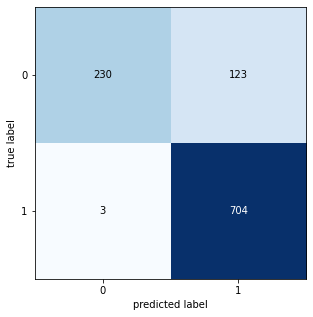

In [123]:
print("predicting...")
predictions_cnn_2 = (cnn_2.predict(t, verbose=1) > 0.5).astype("int32")
print("number of predictions ", len(predictions_cnn_2))

# get the class with highest probability for each sample
#y_pred = (predictions > 0.5).astype("int32")

# get the classification report
print("classification report")
print(classification_report(test_labels, predictions_cnn_2))
#print(classification_report(train_set.labels, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

CM = confusion_matrix(test_labels, predictions_cnn_2)
print("confusion matrix")
print(CM)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

We can see that the CNN-2 does better overall on predicions for both classes, so we can confidently choose CNN-2 as our final model.

### Make a Prediction

In [125]:
#from PIL import Image
import numpy as np
from skimage import transform
from skimage import io
from skimage.color import rgb2gray
def load(filename):
    #np_image = Image.open(filename)
    np_image = io.imread(filename)
    np_image = rgb2gray(np_image)/255
    #np_image = np.array(np_image).astype('float32')

    np_image = transform.resize(np_image, (128, 128, 1))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

image = load(r'E:\COURSES\Advanced Data Science With IBM\Advanced Data Science Capstone\assignment\data\chest_xray\train\PNEUMONIA\person438_bacteria_1889.jpeg')

c:\miniconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  if __name__ == '__main__':


In [126]:
print( cnn_2.predict_classes(image), cnn_2.predict_proba(image)*100, '%')

# The predicted probability is taken as the likelihood of the observation belonging to class 1, or inverted (1 – probability) to give the probability for class 0.

c:\miniconda3\envs\capstone\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
c:\miniconda3\envs\capstone\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


[[1]] [[100.]] %


In the case of a two-class (binary) classification problem, the sigmoid activation function is often used in the output layer. The predicted probability is taken as the likelihood of the observation belonging to class 1, or inverted (1 – probability) to give the probability for class 0

### Save model for deployment

In [130]:
cnn_2.save("cnn_2.ml")

INFO:tensorflow:Assets written to: cnn_2.ml\assets


INFO:tensorflow:Assets written to: cnn_2.ml\assets


In [131]:
test_model = load_model("cnn_2.ml")

In [132]:
# use loaded model to make prediction

print( test_model.predict_classes(image), test_model.predict_proba(image)*100, '%')


[[1]] [[100.]] %


c:\miniconda3\envs\capstone\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
c:\miniconda3\envs\capstone\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
